### Into to neural networks - Function aproximation

In [1]:
%matplotlib inline

import numpy as np
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from pybrain.tools.shortcuts import buildNetwork
from pybrain.structure import TanhLayer
from pybrain.datasets.classification import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.tools.validation import Validator
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

### dataNormalizer
a simple class used to normalize data backwards and forwards.

In [2]:
class dataNormalizer():
    
    def columnMax(self, df, maxVals = None):
        """Normalizes all columns to be a percentage of the max value in the column"""
        
        if maxVals == None:
            maxVals = map(lambda x: max(df[x]), df)
        
        # Loop through all the data
        newData = []
        for column, maxVal in zip(df.columns, maxVals):
            # Gets values for column
            values = list(df[column])
            new = list(map(lambda x: x/maxVal, values))
            newData.append(new)
        return pd.DataFrame(np.transpose(newData), columns=df.columns), maxVals
    
    def columnGlobalMax(self, df):
        globalMax = max(map(lambda x: max(df[x]), df))
        return self.columnMax(df, maxVals = [globalMax]*len(df))
    
    def invert_columnMax(self, df, maxVals):
        """ Function to return a dataframe back to it's origional values using 
        given max values as target max values. In this function maxvals are a 
        required parameter because there needs to be a target value.
        
        If given the output of columnMax using the same parameters, returns dataframe
        origionally given to columMax() (with some minor difference due to issues with
        floating point numbers.)"""
        
        # Loop through all the data
        newData = []
        for column, maxVal in zip(df.columns, maxVals):
            # Gets values for column
            values = list(df[column])
            new = list(map(lambda x: x*maxVal, values))
            newData.append(new)
        return pd.DataFrame(np.transpose(newData), columns=df.columns)
    
    def invert_globalMax(self, df, globalMax):
        return self.invert_columnMax(df, maxVals = [globalMax]*len(df))

In [5]:
# Design of a class

class functionAproximator():
    data_normalizer = dataNormalizer()
    # Network size is a tuple of integers cooresponding to the number of nodes in each layer
    # input data cooresponds to a table of input parameters
    # outputData cooresponds to a list of real values for the 
    def __init__(self, 
                 networkSize, 
                 df, 
                 inputColumns=[], 
                 outputColumns=[], 
                 verbose=False, 
                 normalizeData=False
                ):
        
        self.normalizeData = normalizeData
        if normalizeData == True:
            #= list(map(lambda x: max(df[x]), df))
            df, self.maxValues = self.data_normalizer.columnGlobalMax(df)
        self.networkSize = networkSize
        self.inputData = df[inputColumns]
        self.outputData = df[outputColumns]
        self.fullData = df
        
        self.inputColumns = inputColumns
        self.outputColumns = outputColumns
        
        self.numbInputs = len(self.inputColumns)
        self.numbOutputs = len(self.outputColumns)
        self.dataSize = len(df)
        
        self.verbose=verbose
        
        if self.numbOutputs > 1:
            print "ERROR! Too many outputs for now"
            
    def setupData(self):
        """Take existing data and get it into numpy arrays then
        feed it to the train_test_split function to get training and test data"""
        
        # Converting the input data to a numpy array
        data = self.inputData.as_matrix()
        target = self.outputData.as_matrix()
        
        #data = preprocessing.scale(data)

        # Create z.  We reshape it to an array of 1-element arrays for pyBrain
        #target = target.reshape(self.dataSize,1)

        # Create train/test split
        data_train, data_test, target_train, target_test = train_test_split(
            data, target, test_size=.25, random_state=1
        )
    
        # Create a dataset with 2 inputs and 1 output
        ds_train = SupervisedDataSet(self.numbInputs, self.numbOutputs)

        # add our data to the dataset
        ds_train.setField('input', data_train)
        ds_train.setField('target', target_train)

        # Do the same for the test set
        ds_test = SupervisedDataSet(self.numbInputs, self.numbOutputs)
        ds_test.setField('input', data_test)
        ds_test.setField('target', target_test)
        
        return ds_train, ds_test, target_train, target_test
    def setupNetwork(self):
        self.network = buildNetwork(*self.networkSize, hiddenclass=TanhLayer)
    
    def trainNetwork(self):
        ds_train, ds_test, target_train, target_test = self.setupData()
        
        #print self.network, ds_train
        
        # Create a trainer for the network and training dataset
        trainer = BackpropTrainer(self.network, ds_train)

        # Train for a number of epochs and report accuracy:
        for i in range(10):
            # Train 10 epochs
            trainer.trainEpochs(self.dataSize)

            # Report mean squared error for training and testing sets
            # `network.activateOnDataset` will return the predicted values for each input in the dataset passed to it.
            # Then `Validator.MSE` returns the mean squared error of the returned value with the actual value.
            if self.verbose:
                print("Train MSE:", Validator.MSE(self.network.activateOnDataset(ds_train), target_train))
                print("Test MSE:", Validator.MSE(self.network.activateOnDataset(ds_test), target_test))
                
    def fullSetup(self):
        self.setupNetwork()
        self.trainNetwork()
    
    def getAproximation(self):
        return self.network.activate
    
    def getFullTable(self):
        a = self.getAproximation()
        if self.normalizeData == True:
            print "Bitch im normal"
            df = self.data_normalizer.invert_globalMax(self.fullData, self.maxValues[0])
        else:
            df = self.fullData
        
        df['predicted'] = list(map(lambda x: a(x[1:])[0], self.inputData.itertuples()))
        
        errors = list(map(lambda x,y: (x - y), df[self.outputColumns[0]], df['predicted']))
        df['errors'] = errors
        
        return df

### Simple mathematical equation aproximation

In [6]:
# Function to aproximate:
def foo(a,b):
    a = float(a)
    b = float(b)
    return float(a * a + (b / 3)*a)

def createDataset(function, ranges, number):
    params = list(map(lambda x: list(np.random.uniform(x[0], x[1], number)), ranges))
    zipped = zip(*params)
    
    calculated = list(map(lambda x: function(*x), zipped))
    df = pd.DataFrame(zipped, columns = ['x', 'y'])
    df['z'] = calculated
    
    return df

dataTable = createDataset(foo, [(0,1), (0,1)], 100)


FA_reg = functionAproximator((2,5,1), dataTable, inputColumns = ['x', 'y'], outputColumns = ['z'], verbose=False)
FA_reg.fullSetup()
df_regular = FA_reg.getFullTable().sort(['x', 'y'], ascending=[1, 1])



FA_norm = functionAproximator((2,5,1), dataTable, inputColumns = ['x', 'y'], outputColumns = ['z'], verbose=False, normalizeData=True)
FA_norm.fullSetup()
df_normalized = FA_norm.getFullTable().sort(['x', 'y'], ascending=[1, 1])


/Users/ben/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Bitch im normal


/Users/ben/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


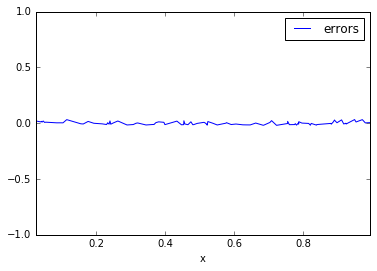

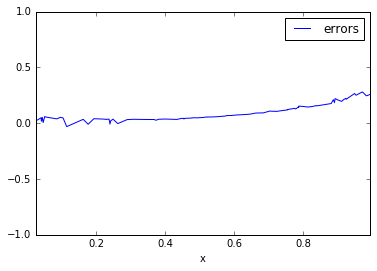

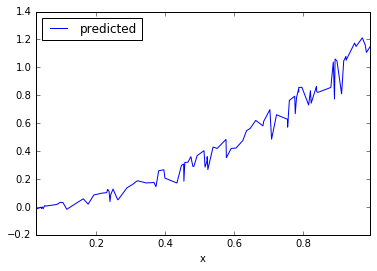

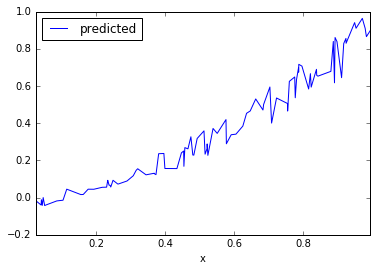

In [7]:
df_regular.plot.line(x='x', y='errors', ylim=(-1,1))
df_normalized.plot.line(x='x', y='errors', ylim=(-1,1))
df_regular.plot.line(x='x', y='predicted')
df_normalized.plot.line(x='x', y='predicted')

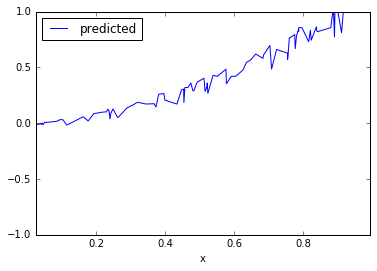

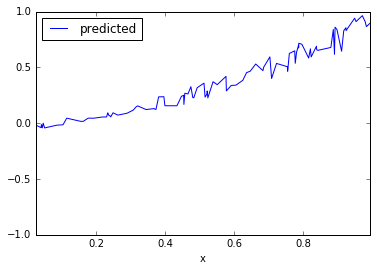

In [8]:
df_regular.plot.line(x='x', y='predicted', ylim=(-1,1))
df_normalized.plot.line(x='x', y='predicted', ylim=(-1,1))

In [ ]:
df.plot.line(x='x', y='z')

### Demonstration of OR gate aproximation

In [ ]:
# Creating data for an XOR gate
inputList = [
                [0, 0],
                [0, 1],
                [1, 0],
                [1, 1]
            ]

outputList = [
                [0],
                [1],
                [1],
                [0]
]

inputData = pd.DataFrame(inputList, columns=['x', 'y'])
outputData = pd.DataFrame(outputList, columns=['z'])

FA = functionAproximator((2,5,1), inputData, outputData)
FA.getFullTable()